<link rel="stylesheet" href="/site-assets/css/style.css">
<link rel="stylesheet" href="/site-assets/css/gemma.css">


##### Copyright 2024 Google LLC.

# Fine-tune PaliGemma with JAX and Flax

<table class="tfo-notebook-buttons" align="left">
<td>
<a target="_blank" href="https://ai.google.dev/gemma/docs/paligemma/fine-tuning-paligemma"><img src="https://ai.google.dev/static/site-assets/images/docs/notebook-site-button.png" height="32" width="32" />View on ai.google.dev</a>
</td>
<td>
<a target="_blank" href="https://colab.research.google.com/github/google/generative-ai-docs/blob/main/site/en/gemma/docs/paligemma/fine-tuning-paligemma.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
</td>
<td>
<a target="_blank" href="https://github.com/google/generative-ai-docs/blob/main/site/en/gemma/docs/paligemma/fine-tuning-paligemma.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
</td>
</table>

This notebook shows how to fine-tune [PaliGemma](https://ai.google.dev/gemma/docs/paligemma) on a vision-language task with [JAX](https://jax.readthedocs.io/en/latest/index.html). *Fine-tuning* is a process that can improve your model's performance on specific tasks or help the model adhere to specific output requirements when instructions aren't sufficient and you have a set of examples that demonstrate the outputs you want. Gemma-based models like PaliGemma require fine-tuning to produce expected results.

### What's in this notebook

This notebook uses the model reference implementation from [`big_vision`](https://github.com/google-research/big_vision)
and shows how to:

 * Install dependencies, and download the PaliGemma model checkpoint and training data
 * Load the model onto GPU devices
 * Prepare the model's inputs for training and inference
 * Fine-tune the model
 * Inspect the output

The training data for this notebook consists of 90 pairs of images and long captions describing them. To make it runnable on a T4 colab runtime, you'll only fine-tune the attention layers of the language model and freeze the other parameters.

This example is for learning purposes only. In a real use case, the amount of data, trainable parameters, training steps and hyper-parameters, and obtained results could be significantly different.

### Before you begin

Before going through this notebook, you should be familiar with Python code, as well as how large language models (LLMs) are trained. You don't need to be familiar with JAX, but basic knowledge about JAX (or similar technologies such as Keras) is helpful when reading through the example code.

## Setup

The following sections explain the preliminary steps for getting a notebook to use a PaliGemma model, including model access, getting an API key, and configuring the notebook runtime.

### Get access to PaliGemma

Before using PaliGemma for the first time, you must request access to the model through Kaggle by completing the following steps:

1. Log in to [Kaggle](https://www.kaggle.com), or create a new Kaggle account if you don't already have one.
1. Go to the [PaliGemma model card](https://www.kaggle.com/models/google/paligemma-2) and click **Request Access**.
1. Complete the consent form and accept the terms and conditions.

### Configure your API key

To use PaliGemma, you must provide your Kaggle username and a Kaggle API key.

To generate a Kaggle API key, open your [**Settings** page in Kaggle](https://www.kaggle.com/settings) and click **Create New Token**. This triggers the download of a `kaggle.json` file containing your API credentials.

Then, in Colab, select **Secrets** (🔑) in the left pane and add your Kaggle username and Kaggle API key. Store your username under the name `KAGGLE_USERNAME` and your API key under the name `KAGGLE_KEY`.


### Select the runtime

To complete this tutorial, you'll need to have a Colab runtime with sufficient resources to run the PaliGemma model. In this case, you can use a T4 GPU:

1. In the upper-right of the Colab window, click the **▾ (Additional connection options)** dropdown menu.
1. Select **Change runtime type**.
1. Under **Hardware accelerator**, select **T4 GPU**.

### Set environment variables

Set the environment variables for `KAGGLE_USERNAME` and `KAGGLE_KEY`.

In [1]:
import os
import flax.serialization
import msgpack
import os

# from google.colab import userdata

# Note: `userdata.get` is a Colab API. If you're not using Colab, set the env
# vars as appropriate or make your credentials available in ~/.kaggle/kaggle.json

os.environ["KAGGLE_USERNAME"] = 'dhruvagarwal1'
os.environ["KAGGLE_KEY"] = 'd494c3f77be2e8080f95596bac32ecd9'

# The T4 runtime is tight on memory to finetune this model. Preallocate
# all memory ahead of time to avoid out-of-memory due to fragmentation.
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.0"

### Fetch the `big_vision` repository and install related dependencies

Download the `big_vision` repository to your Colab notebook from GitHub and install dependencies related to `big_vision` by running the following code.

In [2]:
import os
import sys

# TPUs with
# if "COLAB_TPU_ADDR" in os.environ:
#   raise "It seems you are using Colab with remote TPUs which is not supported."

# Fetch big_vision repository if python doesn't know about it and install
# dependencies needed for this notebook.
if not os.path.exists("big_vision_repo"):
  !git clone --quiet --branch=main --depth=1 \
     https://github.com/google-research/big_vision big_vision_repo

# Append big_vision code to python import path
if "big_vision_repo" not in sys.path:
  sys.path.append("big_vision_repo")

# Install missing dependencies. Assume jax~=0.4.25 with GPU available.
!pip3 install -q "overrides" "ml_collections" "einops~=0.7" "sentencepiece"


### Import JAX and other dependencies

Import JAX and other dependencies required for PaliGemma, like TensorFlow and NumPy.

In [3]:
import base64
import functools
import html
import io
import os
import warnings

import jax
import jax.numpy as jnp
import numpy as np
import ml_collections

import tensorflow as tf
import sentencepiece

from IPython.core.display import display, HTML
from PIL import Image

# Import model definition from big_vision
from big_vision.models.proj.paligemma import paligemma
from big_vision.trainers.proj.paligemma import predict_fns

# Import big vision utilities
import big_vision.datasets.jsonl
import big_vision.utils
import big_vision.sharding

# Don't let TF use the GPU or TPUs
# tf.config.set_visible_devices(["cuda:1"], "GPU")
# tf.config.set_visible_devices([], "TPU")

backend = jax.extend.backend.get_backend()
print(f"JAX version:  {jax.__version__}")
print(f"JAX platform: {backend.platform}")
print(f"JAX devices:  {jax.device_count()}")

def save_checkpoint(params, step, save_dir="checkpoints"):
    os.makedirs(save_dir, exist_ok=True)
    path = os.path.join(save_dir, f"checkpoint_{step:04d}.msgpack")
    with open(path, "wb") as f:
        f.write(flax.serialization.to_bytes(params))
    print(f"✅ Saved checkpoint to: {path}")


2025-05-02 19:56:40.805032: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746215800.830557 1134912 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746215800.838832 1134912 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746215800.860296 1134912 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746215800.860315 1134912 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746215800.860317 1134912 computation_placer.cc:177] computation placer alr

JAX version:  0.6.0
JAX platform: cpu
JAX devices:  1


## Download and configure the model

In this step, you'll download the model checkpoint and configure it so that you can fine-tune it later on. This step shows you how to move model parameters into TPU memory, which is useful for fine-tuning models on devices with limited resources.

### Download the model checkpoint

PaliGemma includes several model variations. For this tutorial, you'll use the base [JAX/FLAX PaliGemma 3B weight model](https://www.kaggle.com/models/google/paligemma-2/jax/paligemma2-3b-pt-224).

Download the model checkpoint from Kaggle by running the following code. This process takes several minutes to complete.

In [4]:
import os
import kagglehub

# Use these for PaliGemma-2 3B 224px²
# LLM_VARIANT = "gemma2_2b"
# MODEL_PATH = "./paligemma2-3b-pt-224.b16.npz"
# KAGGLE_HANDLE = "google/paligemma-2/jax/paligemma2-3b-pt-224"  # Path to fetch from Kaggle.

# Use these for PaliGemma 1:
LLM_VARIANT = "gemma_2b"
MODEL_PATH = "./paligemma-3b-pt-224.f16.npz"
KAGGLE_HANDLE = "google/paligemma/jax/paligemma-3b-pt-224"

if not os.path.exists(MODEL_PATH):
  print("Downloading the checkpoint from Kaggle, this could take a few minutes....")
  MODEL_PATH = kagglehub.model_download(KAGGLE_HANDLE, MODEL_PATH)
  print(f"Model path: {MODEL_PATH}")

TOKENIZER_PATH = "./paligemma_tokenizer.model"
if not os.path.exists(TOKENIZER_PATH):
  print("Downloading the model tokenizer...")
  !gsutil cp gs://big_vision/paligemma_tokenizer.model {TOKENIZER_PATH}
  print(f"Tokenizer path: {TOKENIZER_PATH}")

DATA_DIR="./longcap100"
if not os.path.exists(DATA_DIR):
  print("Downloading the dataset...")
  !gsutil -m -q cp -n -r gs://longcap100/ .
  print(f"Data path: {DATA_DIR}")

Model path: /home/henrytsai/.cache/kagglehub/models/google/paligemma/jax/paligemma-3b-pt-224/1/./paligemma-3b-pt-224.f16.npz


### Configure the model

It's time to actually start configuring the model that you're going to use.

For this notebook, you need to be able to fit your model onto a T4 GPU. Having a limited resource like space constraints means that you have to be mindful of how your model is configured.

If you fine-tune every parameter, your model won't be able to run in the notebook environment. As a result, in this part of the notebook, you'll configure your model so that it has the ability to freeze some of the parameters, and only fine-tune the parameters that really need to be fine-tuned for the model to give you accurate results. In LLMs, parameters are said to be *frozen* when they are no longer actively being used to train the model.

In order to configure your model, you need to:

* Initialize the `model_config` as a [`FrozenConfigDict`](https://github.com/google/ml_collections/tree/master#frozenconfigdict) so that you can freeze some of the parameters and keep memory usage low
* Initialize an instance of the PaliGemma `Model` class using the `model_config` as its configurations
* Load the model parameters into RAM
* Define a `decode` function to sample outputs from the model

This code in this cell takes about a minute to run to completion.

In [5]:
import tensorflow_datasets as tfds
import numpy as np
from PIL import Image
import io

def preprocess_droid_episode(episode, num_frames=4):
    frames = []
    for step in episode["steps"][:num_frames]:
        img = step["observation"]["exterior_image_1_left"].numpy()
        frames.append(Image.fromarray(img))
    
    # Use the main instruction for training target
    target_text = episode["steps"][0]["language_instruction"].numpy().decode("utf-8")
    
    return frames, target_text

def stack_images_horizontally(images):
    widths, heights = zip(*(img.size for img in images))
    new_im = Image.new('RGB', (sum(widths), max(heights)))
    x_offset = 0
    for im in images:
        new_im.paste(im, (x_offset, 0))
        x_offset += im.width
    return new_im


In [6]:
# Define model

# IMPORTANT: Gemma-2 has a "final_logits_softcap" property. Set it to 0.0
# for better transfer results.
model_config = ml_collections.FrozenConfigDict({
    "llm": {"vocab_size": 257_152, "variant": LLM_VARIANT, "final_logits_softcap": 0.0},
    "img": {"variant": "So400m/14", "pool_type": "none", "scan": True, "dtype_mm": "float16"}
})
model = paligemma.Model(**model_config)
tokenizer = sentencepiece.SentencePieceProcessor(TOKENIZER_PATH)

# Load params - this can take up to 1 minute in T4 colabs.
params = paligemma.load(None, MODEL_PATH, model_config)

# Define `decode` function to sample outputs from the model.
decode_fn = predict_fns.get_all(model)['decode']
decode = functools.partial(decode_fn, devices=jax.devices(), eos_token=tokenizer.eos_id())

### Move model parameters into GPU/TPU memory

Now you need to move the model parameters into GPU/TPU memory. First, shard the parameters across the available GPUs, then load the parameters. Here, you'll load the parameters sequentially. This process takes longer than loading them simultaneously, but it requires more RAM than you have available in this notebook.

Finally, print out all of the parameters to see what type each individual parameter is cast to. Frozen parameters are kept as `float16`, while the trainable parameters are cast to `float32`. When you inspect the list, you'll see that most of the parameters have been frozen and are `float16`.

In [7]:
# Create a pytree mask of the trainable params.
def is_trainable_param(name, param):  # pylint: disable=unused-argument
  if name.startswith("llm/layers/attn/"):
    return True
  # if name.startswith("img/head/"):
  #   return True
  # if name.startswith("img/Transformer/encoderblock/"):
  #   # Match: img/Transformer/encoderblock/<index>/...
  #   parts = name.split("/")
  #   if len(parts) > 3 and parts[2].startswith("encoderblock"):
  #     try:
  #       block_num = int(parts[3])  # parts[3] is the block index
  #       return block_num >= 23  # Unfreeze last 4 blocks
  #     except ValueError:
  #       pass  # Ignore any malformed names
  if name.startswith("llm/"):
    return False
  if name.startswith("img/"):
    return False
  raise ValueError(f"Unexpected param name {name}")

trainable_mask = big_vision.utils.tree_map_with_names(is_trainable_param, params)

# If more than one device is available (e.g. multiple GPUs) the parameters can
# be sharded across them to reduce HBM usage per device.
mesh = jax.sharding.Mesh(jax.devices(), ("data"))

data_sharding = jax.sharding.NamedSharding(
    mesh, jax.sharding.PartitionSpec("data"))

params_sharding = big_vision.sharding.infer_sharding(
    params, strategy=[('.*', 'fsdp(axis="data")')], mesh=mesh)

# Yes: Some donated buffers are not usable.
warnings.filterwarnings(
    "ignore", message="Some donated buffers were not usable")

@functools.partial(jax.jit, donate_argnums=(0,), static_argnums=(1,))
def maybe_cast_to_f32(params, trainable):
  # Cast others to float16, since some GPUs don't support bf16.
  return jax.tree.map(lambda p, m: p.astype(jnp.float32)
                      if m else p.astype(jnp.float16),
                      params, trainable)

# Loading all params in simultaneous - albeit much faster and more succinct -
# requires more RAM than the T4 colab runtimes have by default.
# Instead, do it param by param.
params, treedef = jax.tree.flatten(params)
sharding_leaves = jax.tree.leaves(params_sharding)
trainable_leaves = jax.tree.leaves(trainable_mask)
for idx, (sharding, trainable) in enumerate(zip(sharding_leaves, trainable_leaves)):
  params[idx] = big_vision.utils.reshard(params[idx], sharding)
  params[idx] = maybe_cast_to_f32(params[idx], trainable)
  params[idx].block_until_ready()
params = jax.tree.unflatten(treedef, params)

# Print params to show what the model is made of.
def parameter_overview(params):
  for path, arr in big_vision.utils.tree_flatten_with_names(params)[0]:
    print(f"{path:80s} {str(arr.shape):22s} {arr.dtype}")

print(" == Model params == ")
parameter_overview(params)

 == Model params == 
img/Transformer/encoder_norm/bias                                                (1152,)                float16
img/Transformer/encoder_norm/scale                                               (1152,)                float16
img/Transformer/encoderblock/LayerNorm_0/bias                                    (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_0/scale                                   (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_1/bias                                    (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_1/scale                                   (27, 1152)             float16
img/Transformer/encoderblock/MlpBlock_0/Dense_0/bias                             (27, 4304)             float16
img/Transformer/encoderblock/MlpBlock_0/Dense_0/kernel                           (27, 1152, 4304)       float16
img/Transformer/encoderblock/MlpBlock_0/Dense_1/bias                             (2

## Prepare to tune the model

Now that your model is configured, you can tune it. In this step, you'll create your model's inputs as well as the training and validation iterators, view the training examples, and define the training and validation loops.

### Create model inputs

The model checkpoint you're using has already been trained on images of various aspect ratios that have been resized to 224x224 pixels, and to handle tokenized texts.

The code below defines three functions that you'll use in the next step create the model's inputs:

* **`preprocess_image`:** Normalizes the image data. In this case, pre-processing converts the passed-in image to greyscale, removes the alpha layer, and resizes the passed-in image to the size required by the model for image inputs (224x224 pixels).
* **`preprocess_tokens`:** Splits the tokens up and adds flags to mark whether a token is a prefix or suffix token. These flags will be used later on in the code, during the training step and the evaluation loop.
* **`postprocess_tokens`:** Removes any tokens left at and/or after the end-of-sequence (EOS) token and returns the remaining decoded tokens.


In [8]:
def preprocess_image(image, size=224):
  # Model has been trained to handle images of different aspects ratios
  # resized to 224x224 in the range [-1, 1]. Bilinear and antialias resize
  # options are helpful to improve quality in some tasks.
  image = np.asarray(image)
  if image.ndim == 2:  # Convert image without last channel into greyscale.
    image = np.stack((image,)*3, axis=-1)
  image = image[..., :3]  # Remove alpha layer.
  assert image.shape[-1] == 3

  image = tf.constant(image)
  image = tf.image.resize(image, (size, size), method='bilinear', antialias=True)
  return image.numpy() / 127.5 - 1.0  # [0, 255]->[-1,1]

def preprocess_tokens(prefix, suffix=None, seqlen=None):
  # Model has been trained to handle tokenized text composed of a prefix with
  # full attention and a suffix with causal attention.
  separator = "\n"
  tokens = tokenizer.encode(prefix, add_bos=True) + tokenizer.encode(separator)
  mask_ar = [0] * len(tokens)    # 0 to use full attention for prefix.
  mask_loss = [0] * len(tokens)  # 0 to not use prefix tokens in the loss.

  if suffix:
    suffix = tokenizer.encode(suffix, add_eos=True)
    tokens += suffix
    mask_ar += [1] * len(suffix)    # 1 to use causal attention for suffix.
    mask_loss += [1] * len(suffix)  # 1 to use suffix tokens in the loss.

  mask_input = [1] * len(tokens)    # 1 if it's a token, 0 if padding.
  if seqlen:
    padding = [0] * max(0, seqlen - len(tokens))
    tokens = tokens[:seqlen] + padding
    mask_ar = mask_ar[:seqlen] + padding
    mask_loss = mask_loss[:seqlen] + padding
    mask_input = mask_input[:seqlen] + padding

  return jax.tree.map(np.array, (tokens, mask_ar, mask_loss, mask_input))

def postprocess_tokens(tokens):
  tokens = tokens.tolist()  # np.array to list[int]
  try:  # Remove tokens at and after EOS if any.
    eos_pos = tokens.index(tokenizer.eos_id())
    tokens = tokens[:eos_pos]
  except ValueError:
    pass
  return tokenizer.decode(tokens)


### Create the training and validation iterators

Create two iterators:

*   A **training iterator** to allow the training process to go through the data in chunks rather than processing it all at once
    *   This allows you to do some data pre-processing before use
*   A **validation iterator** that allows the training process to iterate over the validation dataset to see how well the tuned model aligned with the provided results

In [16]:
import tensorflow_datasets as tfds
import numpy as np
from PIL import Image
import io
import base64
import html
from IPython.display import HTML, display

# Settings
SEQLEN = 128
NUM_FRAMES = 8  # 🔁 Change this to however many frames you want

# --- Load dataset ---
train_ds = tfds.load("droid_100", split="train[:90%]", data_dir="gs://gresearch/robotics")
val_ds = tfds.load("droid_100", split="train[90%:]", data_dir="gs://gresearch/robotics")

# --- Image preprocessing ---
def preprocess_image(image):
    return image.resize((224, 224))  # for model input

def subsample_frames(images, num_samples):
    if len(images) <= num_samples:
        return images  # not enough frames to sample, just return them all
    indices = np.linspace(0, len(images) - 1, num=num_samples, dtype=int)
    return [images[i] for i in indices]

def stack_images_horizontally(images):
    widths, heights = zip(*(img.size for img in images))
    new_im = Image.new('RGB', (sum(widths), max(heights)))
    x_offset = 0
    for im in images:
        new_im.paste(im, (x_offset, 0))
        x_offset += im.width
    return new_im

def stack_images_grid(images, frames_per_row=4):
    rows = [images[i:i+frames_per_row] for i in range(0, len(images), frames_per_row)]
    stacked_rows = [stack_images_horizontally(row) for row in rows]
    return np.vstack([np.asarray(r) for r in stacked_rows])


# --- Text preprocessing ---
def preprocess_tokens(prefix, suffix=None, seqlen=None):
    separator = "\n"
    tokens = tokenizer.encode(prefix, add_bos=True) + tokenizer.encode(separator)
    mask_ar = [0] * len(tokens)
    mask_loss = [0] * len(tokens)

    if suffix:
        suffix = tokenizer.encode(suffix, add_eos=True)
        tokens += suffix
        mask_ar += [1] * len(suffix)
        mask_loss += [1] * len(suffix)

    mask_input = [1] * len(tokens)

    if seqlen:
        padding = [0] * max(0, seqlen - len(tokens))
        tokens = tokens[:seqlen] + padding
        mask_ar = mask_ar[:seqlen] + padding
        mask_loss = mask_loss[:seqlen] + padding
        mask_input = mask_input[:seqlen] + padding

    return jax.tree.map(np.array, (tokens, mask_ar, mask_loss, mask_input))

def postprocess_tokens(tokens):
    tokens = tokens.tolist()
    try:
        eos_pos = tokens.index(tokenizer.eos_id())
        tokens = tokens[:eos_pos]
    except ValueError:
        pass
    return tokenizer.decode(tokens)

def openx_iterator(ds, repeat=False, shuffle=False):
    ds = ds.shuffle(1000) if shuffle else ds
    ds = ds.repeat() if repeat else ds

    for episode in tfds.as_numpy(ds):
        try:
            steps = list(episode["steps"])
            if len(steps) < NUM_FRAMES:
                continue
            # if len(steps[0]["language_instruction"].decode("utf-8").lower()) <= 0:
            #     continue
            # Extract all frames from episode
            all_images = [Image.fromarray(step["observation"]["exterior_image_1_left"])
                          for step in steps]
            # Subsample evenly spaced frames
            images = subsample_frames(all_images, NUM_FRAMES)

            # ----- ⬇️ Build full grid image from frames (for both display + model) -----
            display_image = stack_images_grid(images)
            display_image = np.asarray(display_image).astype(np.uint8)

            # ----- ⬇️ Resize to 224x224 for model -----
            model_image = Image.fromarray(display_image).resize((224, 224), Image.BILINEAR)
            model_image = np.asarray(model_image).astype(np.float32) / 127.5 - 1.0  # Normalize to [-1, 1]

            # Instruction
            instruction = steps[0]["language_instruction"].decode("utf-8").lower()
            prefix = "caption en"
            tokens, mask_ar, mask_loss, mask_input = preprocess_tokens(prefix, instruction, SEQLEN)

            yield {
                "image": model_image,          # For model (224x224, normalized)
                "image_raw": display_image,    # For rendering (grid)
                "text": np.asarray(tokens),
                "mask_ar": np.asarray(mask_ar),
                "mask_loss": np.asarray(mask_loss),
                "mask_input": np.asarray(mask_input),
            }

        except Exception as e:
            print(f"Skipping due to error: {e}")
            continue


def train_data_iterator():
    return openx_iterator(train_ds, repeat=True, shuffle=True)

def validation_data_iterator():
    return openx_iterator(val_ds, repeat=False, shuffle=False)


In [17]:
# SEQLEN = 128

# train_dataset = big_vision.datasets.jsonl.DataSource(
#     os.path.join(DATA_DIR, "data_train90.jsonl"),
#     fopen_keys={"image": DATA_DIR})

# val_dataset = big_vision.datasets.jsonl.DataSource(
#     os.path.join(DATA_DIR, "data_val10.jsonl"),
#     fopen_keys={"image": DATA_DIR})


# def train_data_iterator():
#   """Never ending iterator over training examples."""
#   # Shuffle examples and repeat so one can train for many epochs.
#   dataset = train_dataset.get_tfdata().shuffle(1_000).repeat()
#   for example in dataset.as_numpy_iterator():
#     image = Image.open(io.BytesIO(example["image"]))
#     image = preprocess_image(image)

#     prefix = "caption en"  # Could also be a different prefix per example.
#     suffix = example["suffix"].decode().lower()
#     tokens, mask_ar, mask_loss, _ = preprocess_tokens(prefix, suffix, SEQLEN)

#     yield {
#         "image": np.asarray(image),
#         "text": np.asarray(tokens),
#         "mask_ar": np.asarray(mask_ar),
#         "mask_loss": np.asarray(mask_loss),
#     }


# def validation_data_iterator():
#   """Single iterator over validation examples."""
#   for example in val_dataset.get_tfdata(ordered=True).as_numpy_iterator():
#     image = Image.open(io.BytesIO(example["image"]))
#     image = preprocess_image(image)

#     prefix = "caption en"  # Could also be a different prefix per example.
#     tokens, mask_ar, _, mask_input = preprocess_tokens(prefix, seqlen=SEQLEN)

#     yield {
#         "image": np.asarray(image),
#         "text": np.asarray(tokens),
#         "mask_ar": np.asarray(mask_ar),
#         "mask_input": np.asarray(mask_input),
#     }


### View training examples

In this notebook, the training data contains 90 images that are paired with long descriptions of what's depicted in the image.

**Note:** Normal training data sets that are meant to be used for practical use cases should contain more images, but this notebook limits the number of data points so that you can train the model in a reasonable amount of time for an example.

The code below prints a random selection of images with their descriptions from the training data set so that you can see what the images and descriptions your model is trained on looks like. Each image is displayed in as a 128x128 pixel JPEG, with the description printed next to the image to the right.


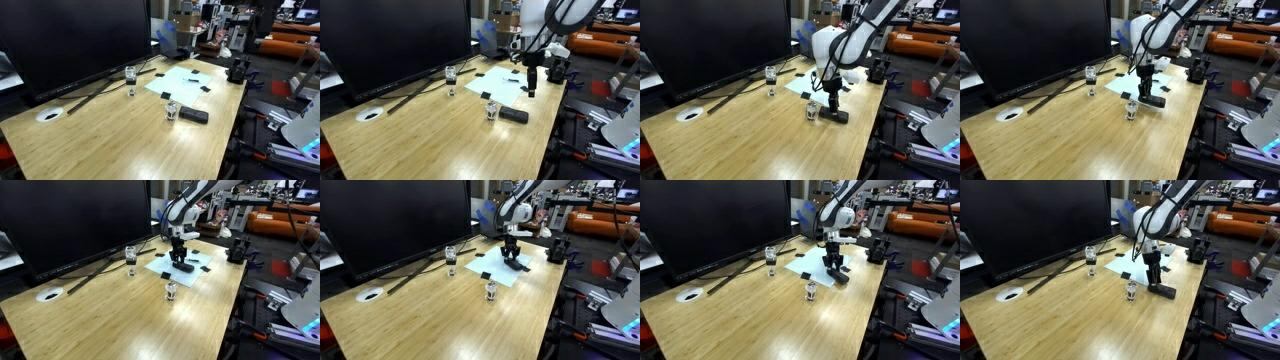
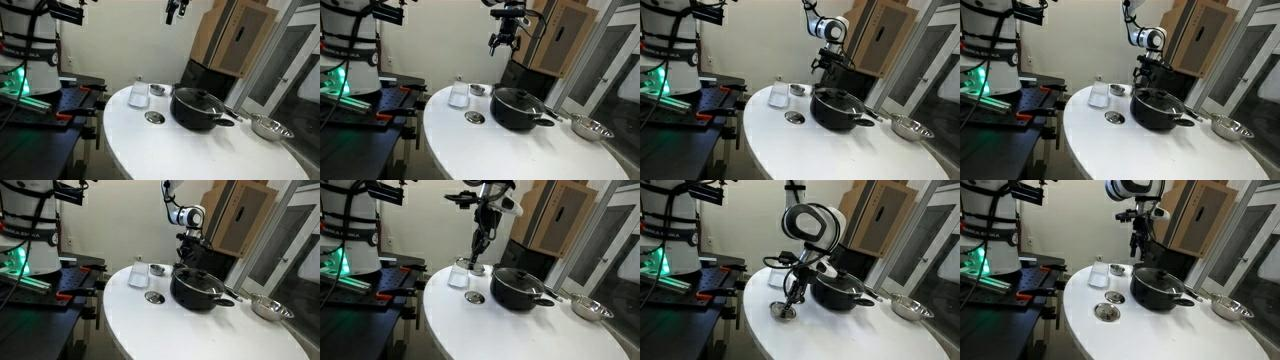
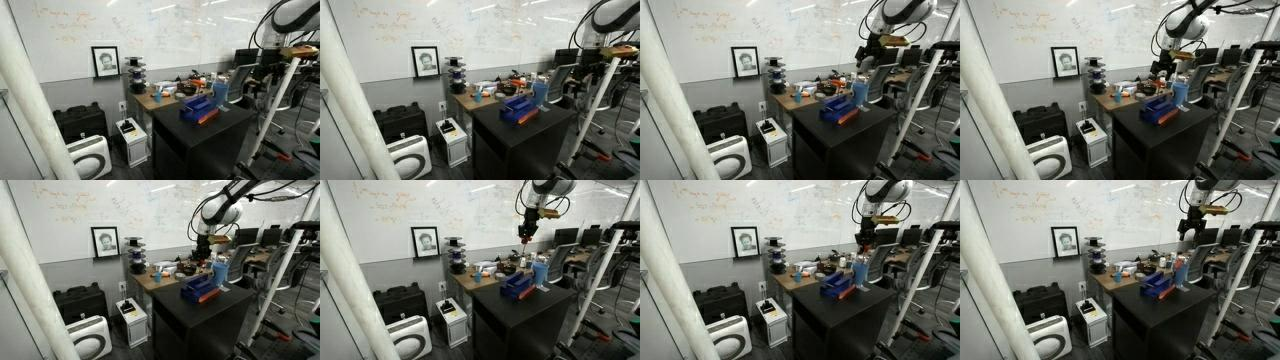
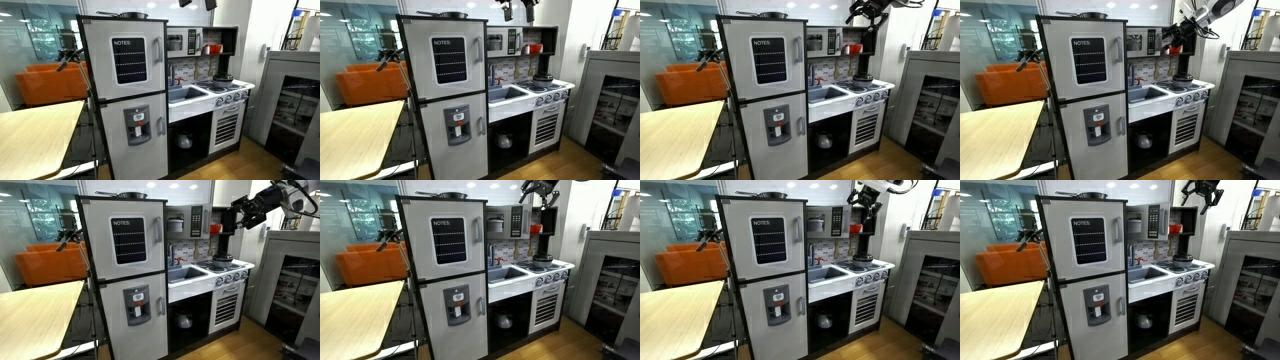
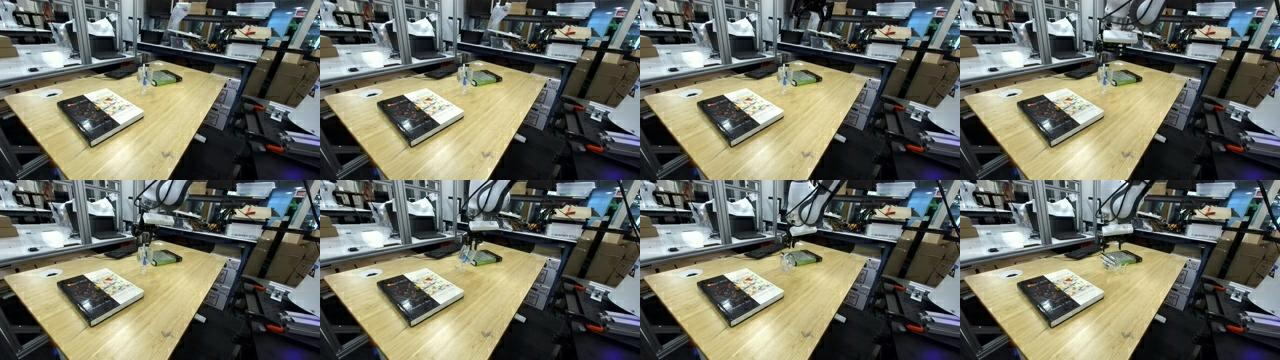
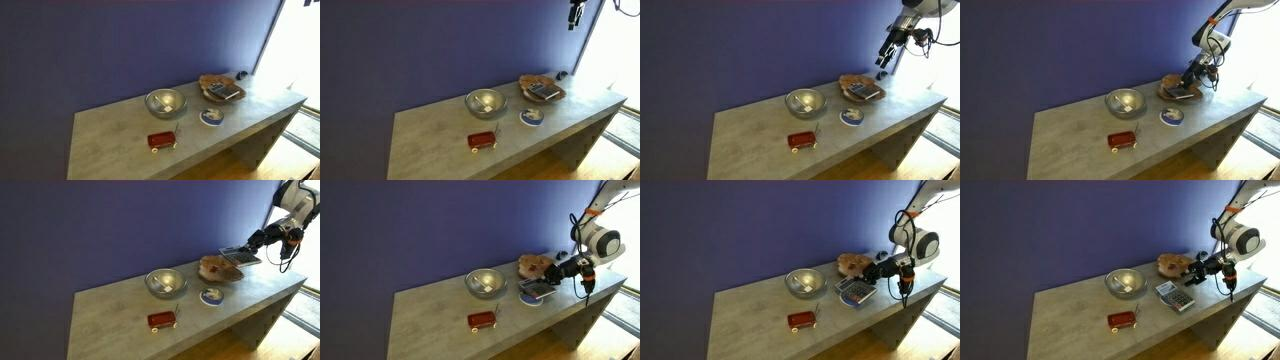
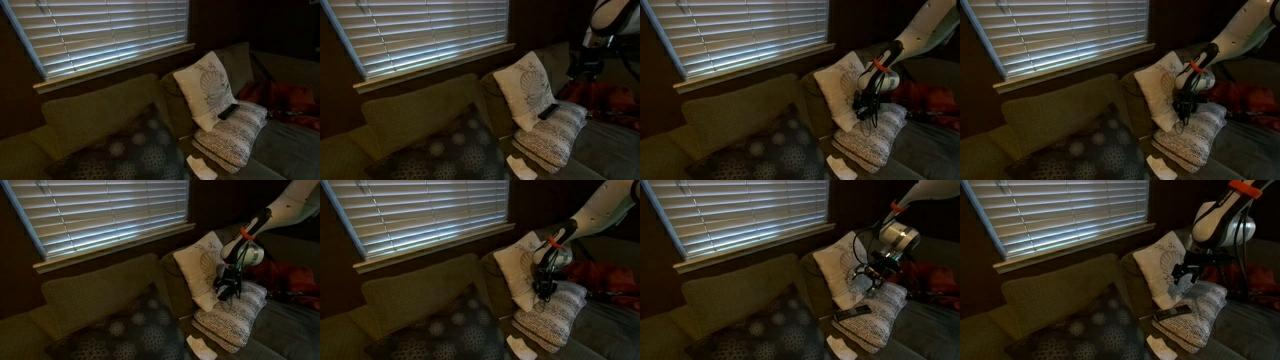
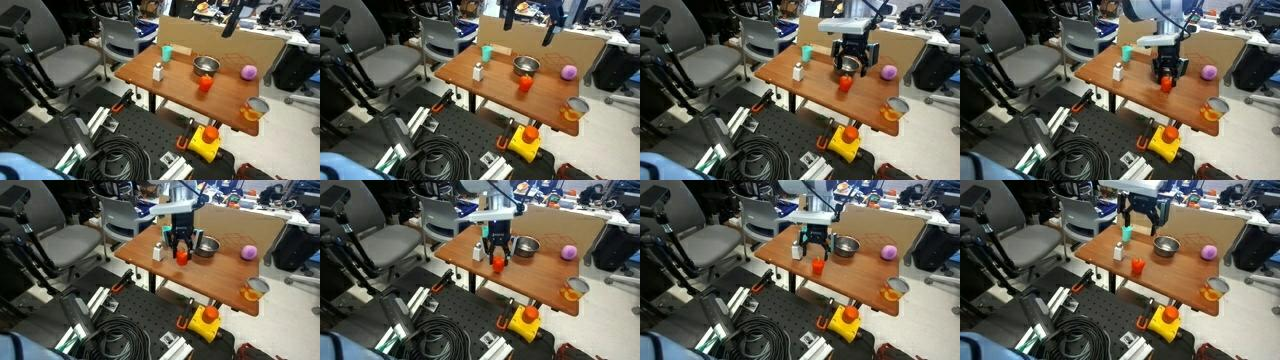

In [18]:
def render_inline(image):
    # If image is float32, assume it's normalized [-1, 1] → convert to uint8
    if image.dtype in [np.float32, np.float64]:
        image = ((image + 1) / 2 * 255).clip(0, 255).astype(np.uint8)

    # Squeeze singleton batch dimensions
    if image.shape[0] == 1 and image.ndim == 4:
        image = image[0]  # (1, H, W, 3) → (H, W, 3)
    if image.shape[0] == 1 and image.ndim == 3:
        image = image.squeeze(0)

    image = Image.fromarray(image)
    with io.BytesIO() as buffer:
        image.save(buffer, format='jpeg')
        image_b64 = base64.b64encode(buffer.getvalue()).decode("utf-8")
        return f"data:image/jpeg;base64,{image_b64}"


def render_example(image, caption):
    return f"""
        <div style="display: inline-flex; align-items: center; justify-content: center;">
            <img style="max-width:100%;" src="{render_inline(image)}" />
            <p style="width:256px; margin:10px; font-size:small;">{html.escape(caption)}</p>
        </div>
    """



# from IPython.display import HTML, display
# import html
# import base64

html_out = ""
for idx, example in zip(range(8), train_data_iterator()):
    caption = postprocess_tokens(example["text"])  # detokenize model input
    caption = caption[len("caption en\n"):]        # remove prompt prefix
    html_out += render_example(example["image_raw"], caption)

display(HTML(html_out))



In [19]:
# The main update_fn using a simple stochastic gradient descent (SGD).
@functools.partial(jax.jit, donate_argnums=(0,))
def update_fn(params, batch, learning_rate):
  imgs, txts, mask_ar = batch["image"], batch["text"], batch["mask_ar"]

  def loss_fn(params):
    text_logits, _ = model.apply({"params": params}, imgs, txts[:, :-1], mask_ar[:, :-1], train=True)
    logp = jax.nn.log_softmax(text_logits, axis=-1)

    # The model takes as input txts[:, :-1] but the loss is defined as predicting
    # next tokens txts[:, 1:]. Additionally, mask_loss[:, 1:] indicates which tokens
    # are part of the loss (e.g. prefix and padded tokens are not included).
    mask_loss = batch["mask_loss"][:, 1:]
    targets = jax.nn.one_hot(txts[:, 1:], text_logits.shape[-1])

    # Compute the loss per example. i.e. the mean of per token pplx.
    # Since each example has a different number of tokens, normalize it.
    token_pplx = jnp.sum(logp * targets, axis=-1)  # sum across vocab_size.
    example_loss = -jnp.sum(token_pplx * mask_loss, axis=-1)  # sum across seq_len.
    example_loss /= jnp.clip(jnp.sum(mask_loss, -1), 1)  # weight by num of tokens.

    # batch_loss: mean of per example loss.
    return jnp.mean(example_loss)

  loss, grads = jax.value_and_grad(loss_fn)(params)

  # Apply gradients to trainable params using SGD.
  def apply_grad(param, gradient, trainable):
    if not trainable: return param
    return param - learning_rate * gradient

  params = jax.tree_util.tree_map(apply_grad, params, grads, trainable_mask)

  return params, loss

# Evaluation/inference loop.
def make_predictions(data_iterator, *, num_examples=None,
                     batch_size=4, seqlen=SEQLEN, sampler="greedy"):
  outputs = []
  while True:
    # Construct a list of examples in the batch.
    examples = []
    try:
      for _ in range(batch_size):
        examples.append(next(data_iterator))
        examples[-1]["_mask"] = np.array(True)  # Indicates true example.
    except StopIteration:
      if len(examples) == 0:
        return outputs

    # Not enough examples to complete a batch. Pad by repeating last example.
    while len(examples) % batch_size:
      examples.append(dict(examples[-1]))
      examples[-1]["_mask"] = np.array(False)  # Indicates padding example.

    # Convert list of examples into a dict of np.arrays and load onto devices.
    batch = jax.tree.map(lambda *x: np.stack(x), *examples)
    batch = big_vision.utils.reshard(batch, data_sharding)

    # Make model predictions
    tokens = decode({"params": params}, batch=batch,
                    max_decode_len=seqlen, sampler=sampler)

    # Fetch model predictions to device and detokenize.
    tokens, mask = jax.device_get((tokens, batch["_mask"]))
    tokens = tokens[mask]  # remove padding examples.
    responses = [postprocess_tokens(t) for t in tokens]

    # Append to html output.
    for example, response in zip(examples, responses):
      outputs.append((example["image"], response))
      if num_examples and len(outputs) >= num_examples:
        return outputs

## Tune the model

Now that you've set everything up and taken a look at the training data, it's time to finally tune the model. The code below runs the training loop for the model for 64 steps and prints the learning rate (`lr` in the printed output) and loss rate for each step.

Every 16 steps, the model prints what its predictions are at that step in the training. This code prints out predictions for the same set of images so that you can see the model's ability to predict descriptions improve over time.

At earlier steps in the training, there's likely issues with the descriptions, such as repeated sentences as the model gets stuck in its predictive loop or unfinished sentences. The model's predictions become steadily more accurate as training progresses. By step 64, the model's predictions should closely resemble the descriptions provided by the training data.

This process takes around 15 minutes to complete on T4 TPUs.

[     2  21209    659    108   1065    974   4433 121944    575    573
  11455  14581 235265      1      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0]
step:  1/16   lr: 0.01500   loss: 1.1598
Model predictions at step 1
Caption put the lid o


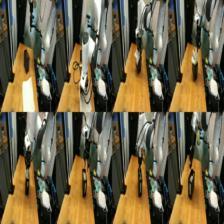
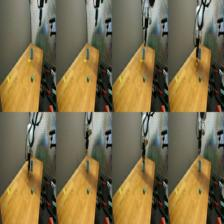
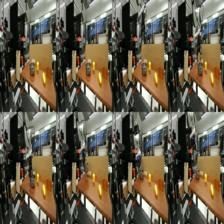
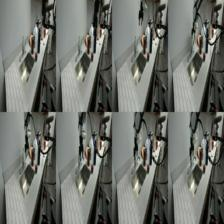

✅ Saved checkpoint to: checkpoints/checkpoint_0001.msgpack
[    2 21209   659   108 18075   908   573  2656  4018   774   573 46548
 34393   578  2040   665   611   573  2674 11193   576  4368   611   573
  1833     1     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]
step:  2/16   lr: 0.03000   loss: 1.9507
Model predictions at step 2
Caption move the black object to the left
Caption 
Caption 
Caption 



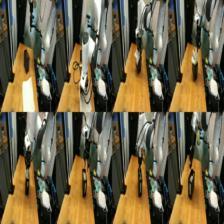
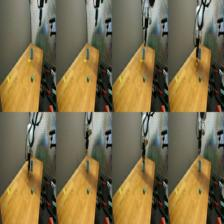
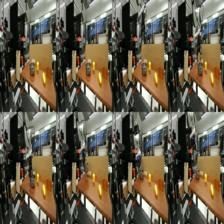
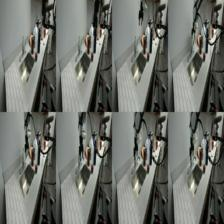

✅ Saved checkpoint to: checkpoints/checkpoint_0002.msgpack
[    2 21209   659   108 23865   573  2656 23729  1401     1     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]
step:  3/16   lr: 0.02967   loss: 1.3257
Model predictions at step 3
Caption put the black bag on the table.
Caption 
Caption 
Caption 



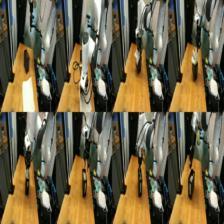
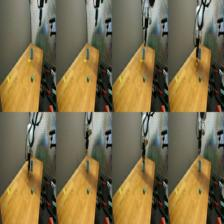
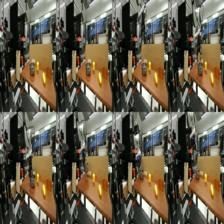
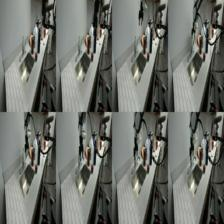

✅ Saved checkpoint to: checkpoints/checkpoint_0003.msgpack
[    2 21209   659   108     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]
step:  4/16   lr: 0.02870   loss: 0.5943
Model predictions at step 4
Caption close the drawer
Caption 
Caption 
Caption 



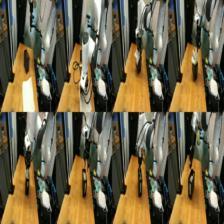
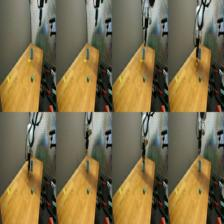
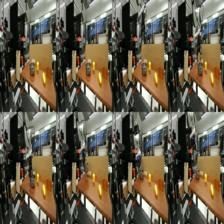
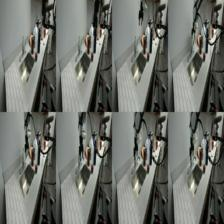

✅ Saved checkpoint to: checkpoints/checkpoint_0004.msgpack
[    2 21209   659   108  2931   573 10436  9113   774   573  7825   745
  3037   577   573 11309     1     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]
step:  5/16   lr: 0.02714   loss: 1.7822
Model predictions at step 5
Caption put the black pen on the table
Caption 
Caption 
Caption 



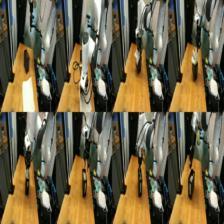
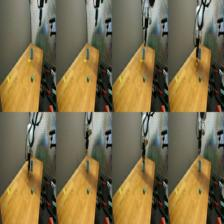
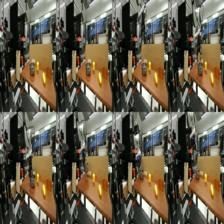
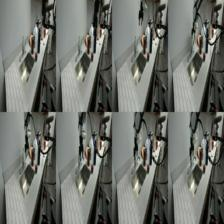

✅ Saved checkpoint to: checkpoints/checkpoint_0005.msgpack
[    2 21209   659   108 18075   908   573  6875 11937   578  2507   665
   575   573 40335     1     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]
step:  6/16   lr: 0.02504   loss: 1.2709
Model predictions at step 6
Caption put the black plastic bag on the table
Caption 
Caption 
Caption 



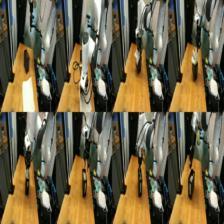
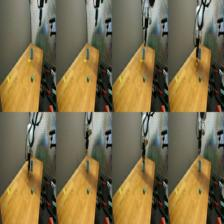
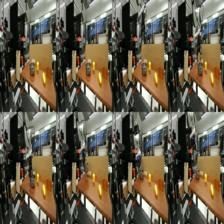
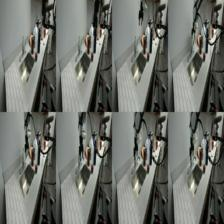

✅ Saved checkpoint to: checkpoints/checkpoint_0006.msgpack
[    2 21209   659   108  2931   573  7190   577   573  1833     1     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]
step:  7/16   lr: 0.02250   loss: 1.0619
Model predictions at step 7
Caption move the black object to the right
Caption 
Caption 
Caption 



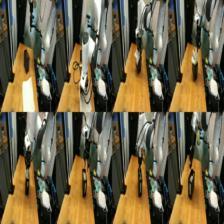
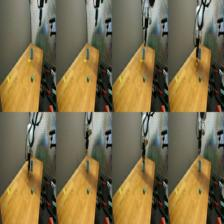
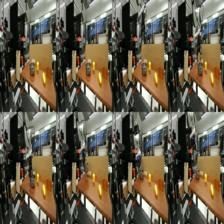
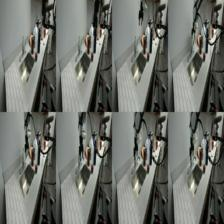

✅ Saved checkpoint to: checkpoints/checkpoint_0007.msgpack
[    2 21209   659   108     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]
step:  8/16   lr: 0.01964   loss: 0.9837
Model predictions at step 8
Caption put the cup on the table
Caption 
Caption 
Caption 



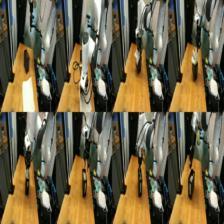
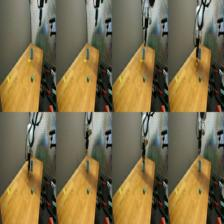
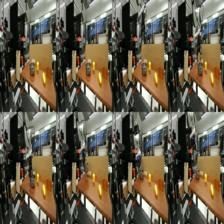
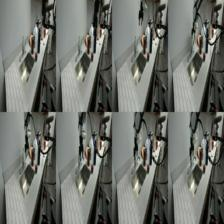

✅ Saved checkpoint to: checkpoints/checkpoint_0008.msgpack
[     2  21209    659    108  18075    908    573   2674  34393    578
   2507    665    575    573  12220   1688   4788    908    573  24416
    578   2507    665    575    573   7190 235269   1492 235269   4788
    908    573   8123  34393    578   2507    665    575    573  12220
 235269    578   6247   4788    908    573  93294  15168    578   2507
    665    575    573   7190      1      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0]
step:  9/16   lr: 0.01657   los


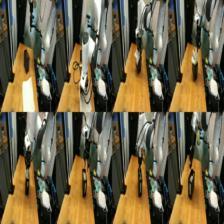
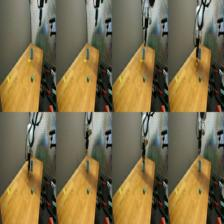
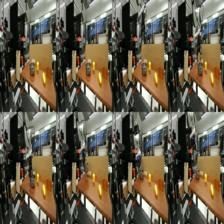
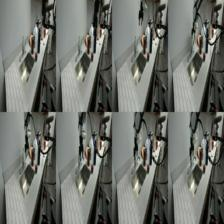

✅ Saved checkpoint to: checkpoints/checkpoint_0009.msgpack
[    2 21209   659   108     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]
step: 10/16   lr: 0.01343   loss: 0.0000
Model predictions at step 10
Caption put the black towel on the table
Caption 
Caption 
Caption 



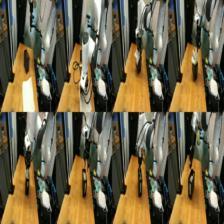
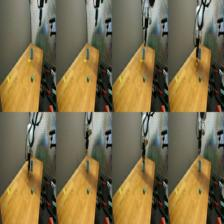
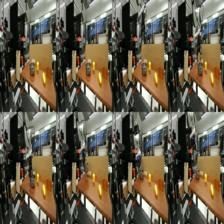
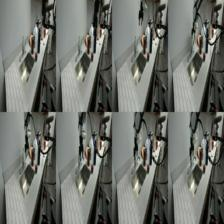

✅ Saved checkpoint to: checkpoints/checkpoint_0010.msgpack
[    2 21209   659   108     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]
step: 11/16   lr: 0.01036   loss: 0.6956
Model predictions at step 11
Caption put the black towel in the white bowl
Caption 
Caption 
Caption 



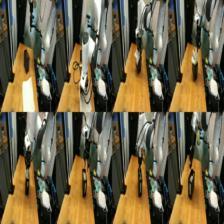
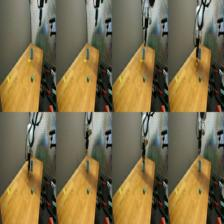
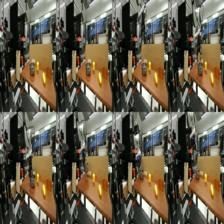
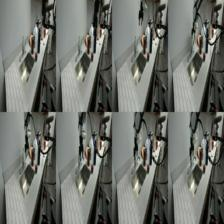

✅ Saved checkpoint to: checkpoints/checkpoint_0011.msgpack
[    2 21209   659   108 18075   908   573 23729   774   573  3037   578
  2507   665   611   573  2688     1     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]
step: 12/16   lr: 0.00750   loss: 0.8609
Model predictions at step 12
Caption put the black cup on the table
Caption 
Caption 
Caption 



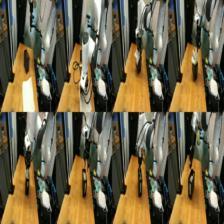
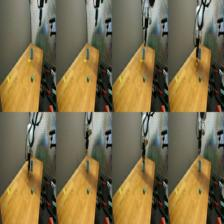
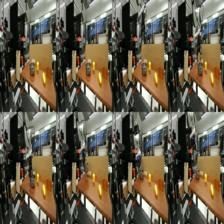
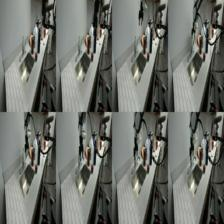

✅ Saved checkpoint to: checkpoints/checkpoint_0012.msgpack
[    2 21209   659   108     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]
step: 13/16   lr: 0.00496   loss: 0.7780
Model predictions at step 13
Caption put the black cup on the table
Caption 
Caption 
Caption 



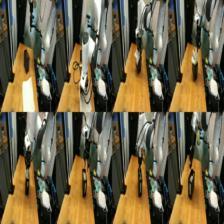
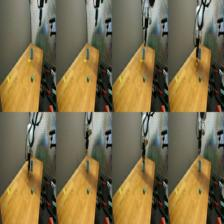
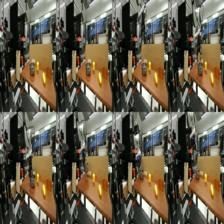
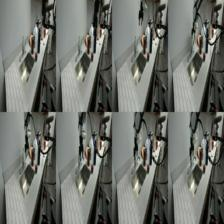

✅ Saved checkpoint to: checkpoints/checkpoint_0013.msgpack
[    2 21209   659   108  9399   573  3008   921   576   573 14581   578
  2040   665   611   573  3037     1     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]
step: 14/16   lr: 0.00286   loss: 0.4378
Model predictions at step 14
Caption put the black cup on the table
Caption 
Caption 
Caption 



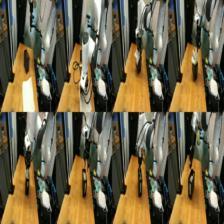
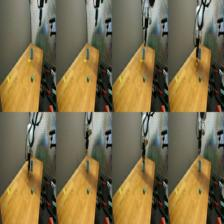
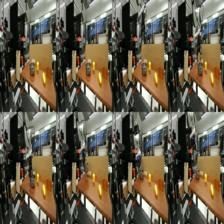
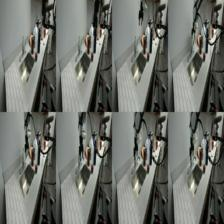

✅ Saved checkpoint to: checkpoints/checkpoint_0014.msgpack
[    2 21209   659   108  2931   573  5570   577   573  2257  2172   575
   573 61055     1     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]
step: 15/16   lr: 0.00130   loss: 1.1591
Model predictions at step 15
Caption put the black cup on the table
Caption 
Caption 
Caption 



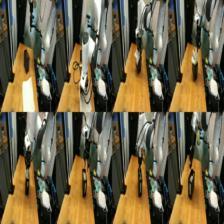
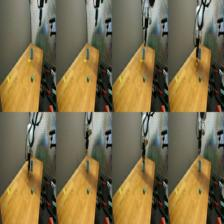
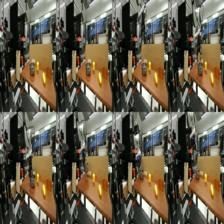
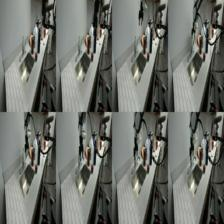

✅ Saved checkpoint to: checkpoints/checkpoint_0015.msgpack
[    2 21209   659   108     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]
step: 16/16   lr: 0.00033   loss: 0.8974
Model predictions at step 16
Caption put the black cup on the table
Caption 
Caption 
Caption 



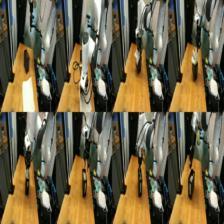
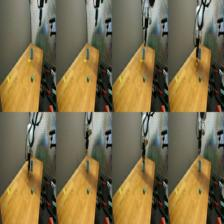
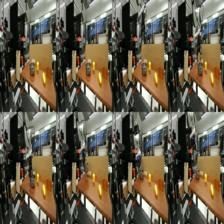
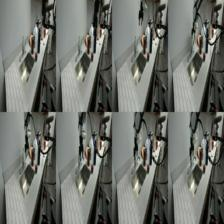

✅ Saved checkpoint to: checkpoints/checkpoint_0016.msgpack


In [20]:
# Run a short training loop with cosine learning rate schedule.
#
# Note: the first step can be quite slow on some machines (up to several minutes)
# due to XLA compilation of the jax.jit'd function.
#
# %%time

BATCH_SIZE = 8
TRAIN_EXAMPLES = 128
LEARNING_RATE = 0.03

TRAIN_STEPS = TRAIN_EXAMPLES // BATCH_SIZE
EVAL_STEPS = 1

train_data_it = train_data_iterator()

sched_fn = big_vision.utils.create_learning_rate_schedule(
    total_steps=TRAIN_STEPS+1, base=LEARNING_RATE,
    decay_type="cosine", warmup_percent=0.10)
for step in range(1, TRAIN_STEPS+1):
  # Make list of N training examples.
  examples = [next(train_data_it) for _ in range(BATCH_SIZE)]
  print(examples[0]['text'])

  # Convert list of examples into a dict of np.arrays and load onto devices.
  batch = jax.tree.map(lambda *x: np.stack(x), *examples)
  batch = big_vision.utils.reshard(batch, data_sharding)

  # Training step and report training loss
  learning_rate = sched_fn(step)
  params, loss = update_fn(params, batch, learning_rate)

  loss = jax.device_get(loss)
  print(f"step: {step:2d}/{TRAIN_STEPS:2d}   lr: {learning_rate:.5f}   loss: {loss:.4f}")

  if (step % EVAL_STEPS) == 0:
    print(f"Model predictions at step {step}")
    html_out = ""
    for image, caption in make_predictions(
        validation_data_iterator(), num_examples=4, batch_size=4):
      html_out += render_example(image, caption)
      print("Caption", caption)
    display(HTML(html_out))
    save_checkpoint(params, step)



## Output

The validation data for this notebook consists of just 10 images. In normal code, you would likely have many more data points for validation, but for this notebook, run the following code to generate descriptions for all 10 images. After tuning the model, these descriptions should be very similar in form and content coverage to the descriptions included with the training data that you looked at earlier in this notebook.

Run the below code to generate descriptions for the validation data set.

Model predictions



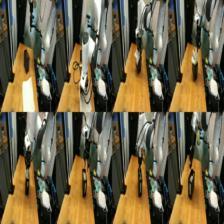
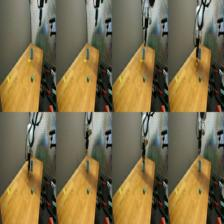
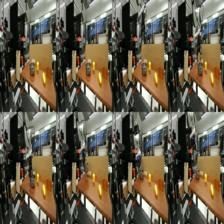
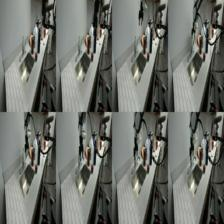
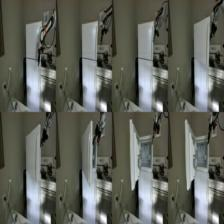
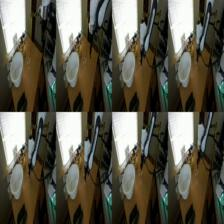
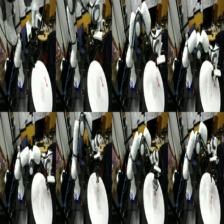
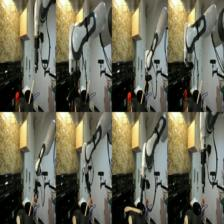
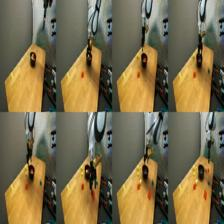
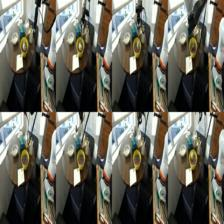

In [21]:
# The validation data consists of 10 images in a different domain than training
# data.
# %%time

print("Model predictions")
html_out = ""
for image, caption in make_predictions(validation_data_iterator(), batch_size=4):
  html_out += render_example(image, caption)
display(HTML(html_out))


In [22]:
import os
print("This notebook kernel’s PID is", os.getpid())


This notebook kernel’s PID is 1134912


In [23]:
def load_checkpoint(path):
    with open(path, "rb") as f:
        return flax.serialization.from_bytes(params, f.read())
load_checkpoint("checkpoints/checkpoint_0016.msgpack")

{'img': {'Transformer': {'encoder_norm': {'bias': array([0.364 , 0.3037, 0.1815, ..., 0.0364, 0.2598, 0.0682], dtype=float16),
    'scale': array([1.627, 1.429, 1.593, ..., 1.607, 1.705, 1.412], dtype=float16)},
   'encoderblock': {'LayerNorm_0': {'bias': array([[-1.4296e-03, -4.4680e-04,  1.2032e-02, ..., -1.6586e-02,
              3.0563e-02,  2.0051e-04],
            [-3.0777e-02, -4.3259e-03, -3.6788e-04, ..., -2.3285e-02,
              6.2744e-02, -1.0300e-03],
            [-3.0807e-02, -6.6109e-03,  3.4785e-04, ..., -4.5395e-03,
             -4.4136e-03,  7.5317e-02],
            ...,
            [ 1.0223e-01, -1.4819e-01,  6.5002e-02, ...,  7.9895e-02,
             -6.2158e-01,  7.1472e-02],
            [-1.3452e-01, -3.0777e-02,  1.0061e-03, ...,  1.6357e-01,
             -5.8740e-01,  3.2471e-02],
            [-1.4771e-01,  7.5195e-02, -4.9683e-02, ...,  1.7322e-01,
             -1.4258e-01, -2.3605e-02]], dtype=float16),
     'scale': array([[ 3.308e-01, -5.302e-04,  6.738e-0